<a href="https://colab.research.google.com/github/Ackermann99/Self-Driving-Car/blob/main/Behavioural_cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
!git clone https://github.com/Ackermann99/Training-track.git

fatal: destination path 'Training-track' already exists and is not an empty directory.


In [140]:
ls Training-track

driving_log.csv  IMG/


In [141]:
!pip3 install imgaug

In [142]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import ntpath
import pandas as pd
import random

In [143]:
datadir = "Training-track"
columns = ["center", "left", "right", "steering", "throttle", "reverse", "speed"]
data = pd.read_csv(os.path.join(datadir, "driving_log.csv"), names = columns)
pd.set_option("display.max_colwidth", None)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,D:\OnlineCourse\Udemy-Self-driving-car\Behavioural-Cloning\Data\IMG\center_2021_05_16_17_20_33_286.jpg,D:\OnlineCourse\Udemy-Self-driving-car\Behavioural-Cloning\Data\IMG\left_2021_05_16_17_20_33_286.jpg,D:\OnlineCourse\Udemy-Self-driving-car\Behavioural-Cloning\Data\IMG\right_2021_05_16_17_20_33_286.jpg,0.0,0.0,0.0,0.000078
1,D:\OnlineCourse\Udemy-Self-driving-car\Behavioural-Cloning\Data\IMG\center_2021_05_16_17_20_33_386.jpg,D:\OnlineCourse\Udemy-Self-driving-car\Behavioural-Cloning\Data\IMG\left_2021_05_16_17_20_33_386.jpg,D:\OnlineCourse\Udemy-Self-driving-car\Behavioural-Cloning\Data\IMG\right_2021_05_16_17_20_33_386.jpg,0.0,0.0,0.0,0.000078
2,D:\OnlineCourse\Udemy-Self-driving-car\Behavioural-Cloning\Data\IMG\center_2021_05_16_17_20_33_488.jpg,D:\OnlineCourse\Udemy-Self-driving-car\Behavioural-Cloning\Data\IMG\left_2021_05_16_17_20_33_488.jpg,D:\OnlineCourse\Udemy-Self-driving-car\Behavioural-Cloning\Data\IMG\right_2021_05_16_17_20_33_488.jpg,0.0,0.0,0.0,0.000078
3,D:\OnlineCourse\Udemy-Self-driving-car\Behavioural-Cloning\Data\IMG\center_2021_05_16_17_20_33_591.jpg,D:\OnlineCourse\Udemy-Self-driving-car\Behavioural-Cloning\Data\IMG\left_2021_05_16_17_20_33_591.jpg,D:\OnlineCourse\Udemy-Self-driving-car\Behavioural-Cloning\Data\IMG\right_2021_05_16_17_20_33_591.jpg,0.0,0.0,0.0,0.000080
4,D:\OnlineCourse\Udemy-Self-driving-car\Behavioural-Cloning\Data\IMG\center_2021_05_16_17_20_33_693.jpg,D:\OnlineCourse\Udemy-Self-driving-car\Behavioural-Cloning\Data\IMG\left_2021_05_16_17_20_33_693.jpg,D:\OnlineCourse\Udemy-Self-driving-car\Behavioural-Cloning\Data\IMG\right_2021_05_16_17_20_33_693.jpg,0.0,0.0,0.0,0.000078


In [144]:
#truncating center, left, right image path to just the end leaf
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data["center"] = data["center"].apply(path_leaf)
data["left"] = data["left"].apply(path_leaf)
data["right"] = data["right"].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_05_16_17_20_33_286.jpg,left_2021_05_16_17_20_33_286.jpg,right_2021_05_16_17_20_33_286.jpg,0.0,0.0,0.0,0.000078
1,center_2021_05_16_17_20_33_386.jpg,left_2021_05_16_17_20_33_386.jpg,right_2021_05_16_17_20_33_386.jpg,0.0,0.0,0.0,0.000078
2,center_2021_05_16_17_20_33_488.jpg,left_2021_05_16_17_20_33_488.jpg,right_2021_05_16_17_20_33_488.jpg,0.0,0.0,0.0,0.000078
3,center_2021_05_16_17_20_33_591.jpg,left_2021_05_16_17_20_33_591.jpg,right_2021_05_16_17_20_33_591.jpg,0.0,0.0,0.0,0.000080
4,center_2021_05_16_17_20_33_693.jpg,left_2021_05_16_17_20_33_693.jpg,right_2021_05_16_17_20_33_693.jpg,0.0,0.0,0.0,0.000078


[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]
[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


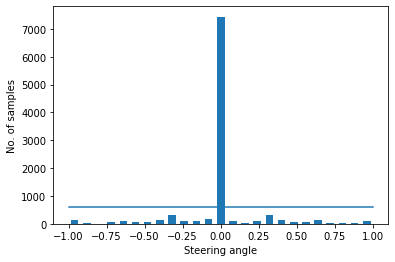

In [145]:
"""visualising the data on the basis of steering angles """

num_bins = 25  #x-axis categorical distribution for bar graph
samples_per_bin = 600    #to limit the bar graph
hist, bins = np.histogram(data["steering"], num_bins)
print(bins)
center = (bins[:-1] + bins[1:]) * 0.5   #to center the graph at 0 
print(center)
plt.bar(center, hist, width=0.05)
plt.xlabel("Steering angle")
plt.ylabel("No. of samples")
plt.plot((np.min(data["steering"]), np.max(data["steering"])), (samples_per_bin, samples_per_bin))

Initial total data length:  9874
Length of removed data:  6840
Length after removal:  3034


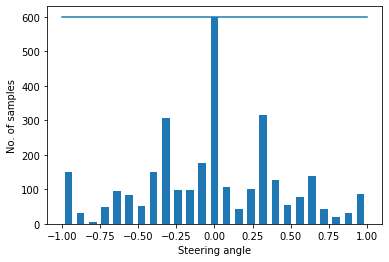

In [146]:
"""cutting off biased values to get more uniformed data"""

"""commented block only needs to run for once """
# print("Initial total data length: ", len(data))
# removed_list = []
# for j in range(num_bins):
#   bin_list = []
#   for i in range(len(data["steering"])):
#     if data["steering"][i] >= bins[j] and data["steering"][i] <= bins[j+1]:
#       bin_list.append(i)
#   bin_list = shuffle(bin_list)
#   bin_list = bin_list[samples_per_bin:]
#   removed_list.extend(bin_list)

# print("Length of removed data: ", len(removed_list))
# data.drop(data.index[removed_list], inplace=True)
# print("Length after removal: ", len(data))

hist, _ = np.histogram(data["steering"], num_bins)
plt.bar(center, hist, width=0.05)
plt.xlabel("Steering angle")
plt.ylabel("No. of samples")
plt.plot((np.min(data["steering"]), np.max(data["steering"])), (samples_per_bin, samples_per_bin))

In [147]:
"""converting the data into array"""
print(data.iloc[1])

def load_img_steering(datadir, df):
  image_path = []
  steering_angle = []
  for i in range(len(df)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering_angle.append(float(indexed_data[3]))
  
  image_paths = np.asarray(image_path)
  steering_angles = np.asarray(steering_angle)
  return image_paths, steering_angles

image_paths, steering_angles = load_img_steering(datadir + "/IMG", data)

center      center_2021_05_16_17_20_34_616.jpg
left          left_2021_05_16_17_20_34_616.jpg
right        right_2021_05_16_17_20_34_616.jpg
steering                                     0
throttle                               0.50996
reverse                                      0
speed                                  1.38805
Name: 13, dtype: object


In [148]:
"""splitting data into training set and validation set"""
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering_angles, test_size=0.2, random_state=8)
print("Training Samples: {}\nValidation Samples: {}".format(len(X_train), len(X_valid)))

Training Samples: 2427
Validation Samples: 607


Text(0.5, 1.0, 'Validation Set')

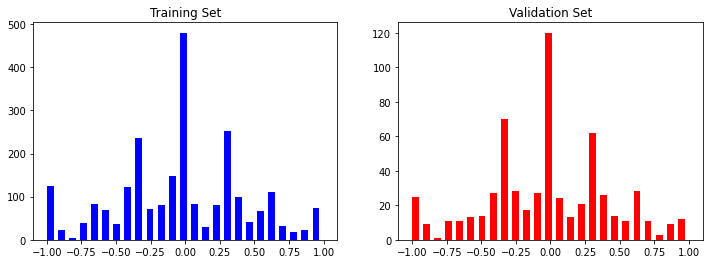

In [149]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color="blue")
axes[0].set_title("Training Set")
axes[1].hist(y_valid, bins=num_bins, width=0.05, color="red")
axes[1].set_title("Validation Set")

In [150]:
"""Image augmentation - Zoom-in"""

def zoom(img):
  zoom = iaa.Affine(scale=(1, 1.3))   #zoom-in to 30%
  img = zoom.augment_image(img)
  return img

Text(0.5, 1.0, 'Zoomed Image')

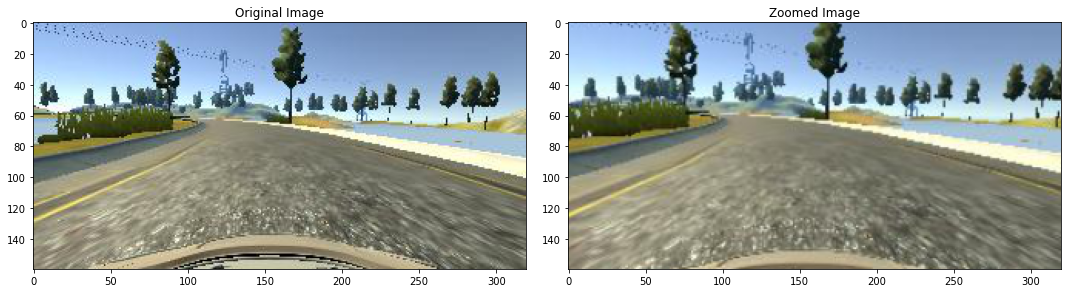

In [183]:
image = image_paths[215]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[1].imshow(zoomed_image)
axes[1].set_title("Zoomed Image")

In [152]:
"""Image augmentation - Panning"""
def pan(img):
  pan = iaa.Affine(translate_percent= {"x": (-0.1, 0.1), "y": (-0.1, 0.1)})   #translating on defined axis
  img = pan.augment_image(img)
  return img

Text(0.5, 1.0, 'Panned Image')

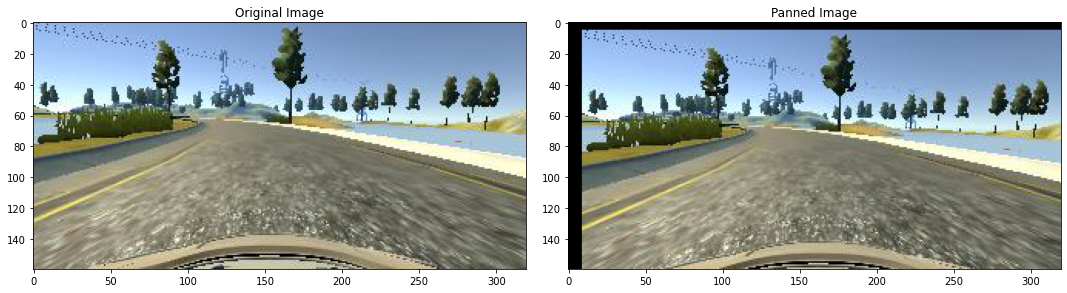

In [184]:
image = image_paths[215]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[1].imshow(panned_image)
axes[1].set_title("Panned Image")

In [154]:
"""Image augmentation - brightness"""
def img_random_brightness(img):
  bright = iaa.Multiply((0.2, 1.2))    #brightness range 0.2-1.2
  img = bright.augment_image(img)
  return img

Text(0.5, 1.0, 'Brightness Altered Image')

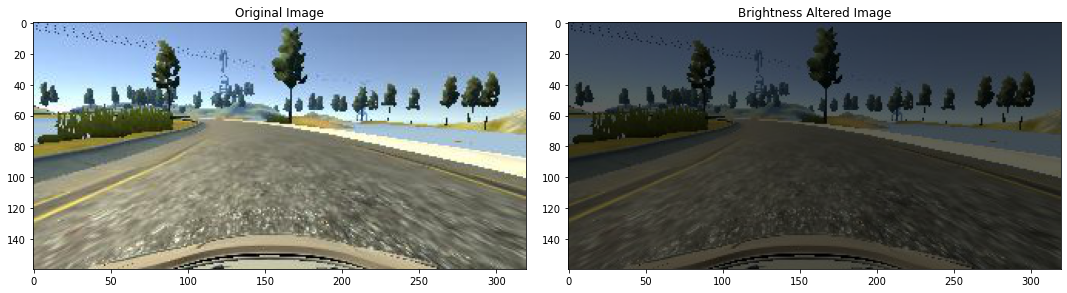

In [185]:
image = image_paths[215]
original_image = mpimg.imread(image)
bright_image = img_random_brightness(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[1].imshow(bright_image)
axes[1].set_title("Brightness Altered Image")

In [156]:
"""Image augmentation - Flipping"""
def img_random_flip(img, steering_angle):
  img = cv2.flip(img, 1)    #1=horizontal flip
  steering_angle = -steering_angle
  return img, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle : 0.14899289999999998')

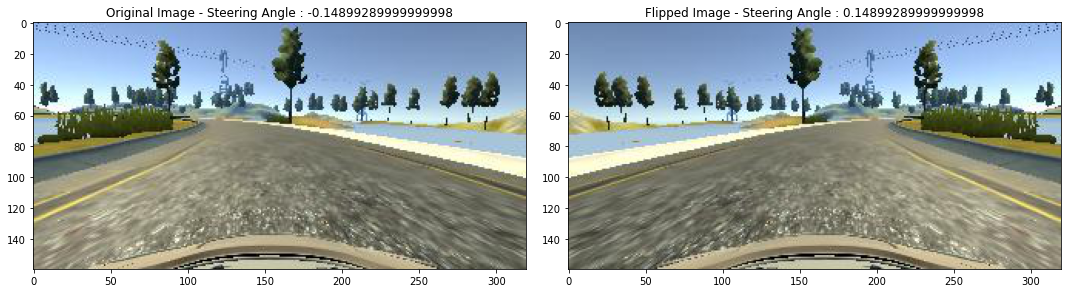

In [186]:
image = image_paths[215]
steering_angle = steering_angles[215]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title("Original Image - "+ "Steering Angle : " + str(steering_angle))
axes[1].imshow(flipped_image)
axes[1].set_title("Flipped Image - "+ "Steering Angle : " + str(flipped_steering_angle))

In [158]:
"""Function to apply augmentation randomly for 50% of the time"""
def random_augment(image, steering_angle):
  image = mpimg.imread(image)

  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)

  return image, steering_angle

In [159]:
# ncol = 2
# nrow = 10

# fig, axes = plt.subplots(nrow, ncol, figsize= (15, 50))
# fig.tight_layout()

# for i in range(nrow):
#   randnum = random.randint(0, len(image_paths) - 1)
#   random_image = image_paths[randnum]
#   random_steering = steering_angles[randnum]

#   original_image = mpimg.imread(random_image)
#   augmented_image, augmented_steering = random_augment(random_image, random_steering)

#   axes[i][0].imshow(original_image)
#   axes[i][0].set_title("Original Image")
#   axes[i][1].imshow(augmented_image)
#   axes[i][1].set_title("Augmented Image")


In [160]:
def img_preprocessing(image):
  image = image[60:135, :, :]
  image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
  image = cv2.GaussianBlur(image, (3, 3), 0)
  image = cv2.resize(image, (200, 66))
  image = image/255
  return image

In [162]:
#batch generator for augmenting and preprocessing images randomly
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      #checks if the data is from training data
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocessing(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [163]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(X_train_gen[0])
axes[0].set_title("Training Image")
axes[1].imshow(X_valid_gen[0])
axes[1].set_title("Validation Image")

In [176]:
def nvdia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2,2), input_shape=(66, 200, 3),activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, (3, 3), activation="elu"))
  model.add(Conv2D(64, (3, 3), activation="elu"))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation="elu"))
  # model.add(Dropout(0.5))

  model.add(Dense(50, activation="elu"))
  model.add(Dense(10, activation="elu"))
  model.add(Dense(1))

  model.compile(Adam(lr=0.001), loss="mse")
  return model

In [177]:
model = nvdia_model()
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1152)             

In [178]:
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 163s 543ms/step - loss: 0.3831 - val_loss: 0.1884
Epoch 2/10
300/300 [==============================] - 161s 539ms/step - loss: 0.2057 - val_loss: 0.1566
Epoch 3/10
300/300 [==============================] - 163s 544ms/step - loss: 0.1835 - val_loss: 0.1252
Epoch 4/10
300/300 [==============================] - 162s 542ms/step - loss: 0.1548 - val_loss: 0.1214
Epoch 5/10
300/300 [==============================] - 162s 542ms/step - loss: 0.1358 - val_loss: 0.1065
Epoch 6/10
300/300 [==============================] - 162s 540ms/step - loss: 0.1318 - val_loss: 0.1054
Epoch 7/10
300/300 [==============================] - 161s 540ms/step - loss: 0.1261 - val_loss: 0.1103
Epoch 8/10
300/300 [==============================] - 162s 542ms/step - loss: 0.1192 - val_loss: 0.1063
Epoch 9/10
300/300 [==============================] - 162s 541ms/step - loss: 0.1135 - val_loss: 0.1038
Epoch 10/10
300/300 [==============================] - 161s 539m

Text(0.5, 0, 'Epochs')

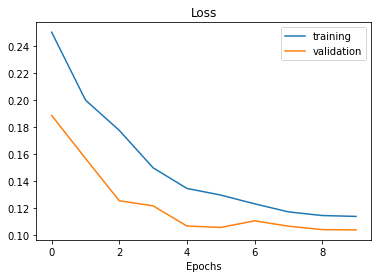

In [179]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["training", "validation"])
plt.title("Loss")
plt.xlabel("Epochs")

In [181]:
model.save("model.h5")

In [182]:
from google.colab import files
files.download("model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>